In [4]:
import numpy as np
import pandas as pd

In [5]:
df_train = pd.read_csv("pendigits.tra", header = None)
df_test = pd.read_csv("pendigits.tes", header = None)

In [6]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,0,82,9,59,56,34,41,0,10,30,3,67,42,96,100,100,5
7490,49,100,0,70,24,56,100,65,86,85,44,77,21,38,6,0,4
7491,100,98,60,100,24,87,3,58,35,51,58,26,36,0,0,5,5
7492,59,65,91,100,84,96,72,50,51,8,0,0,45,1,100,0,1


In [8]:
x_train = df_train.iloc[:,:16]
y_train = df_train.iloc[:,16]
x_test = df_test.iloc[:,:16]
y_test = df_test[16]

In [9]:
print(f"Shape of x_train: {x_train.shape} and shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape} and shape of y_test: {y_test.shape}")

Shape of x_train: (7494, 16) and shape of y_train: (7494,)
Shape of x_test: (3498, 16) and shape of y_test: (3498,)


In [10]:
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
 
 
    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch
        if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.
 
    Attributes
    -----------
    eval_ : dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training.
 
    """
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
 
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
 
        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
 
        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)
 
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
 
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
 
    def _forward(self, X):
        """Compute forward propagation step"""
 
        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
 
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
 
        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]
 
        z_out = np.dot(a_h, self.w_out) + self.b_out
        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
 
        return z_h, a_h, z_out, a_out
 
    def _compute_cost(self, y_enc, output):
        """Compute cost function.
 
        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)
 
        Returns
        ---------
        cost : float
            Regularized cost
 
        """
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
 
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    def predict(self, X):
        
        """Predict class labels
 
        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.
 
        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.
 
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
 
    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.
 
        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training
 
        Returns:
        ----------
        self
 
        """
        n_output = np.unique(y_train).shape[0] # no. of class
        #labels
        n_features = X_train.shape[1]
 
        ########################
        # Weight initialization
        ########################
 
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
 
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
 
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
 
        y_train_enc = self._onehot(y_train, n_output)
 
        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                bb = X_train.iloc[batch_idx]
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(bb)
                
                ##################
                # Backpropagation
                ##################
                
                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]
                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_examples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)
                
                # [n_features, n_examples] dot [n_examples,
                # n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train.iloc[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                # [n_hidden, n_examples] dot [n_examples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            #############
            # Evaluation
            #############
            
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
            output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f ' '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
            (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        
        return self


In [11]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=200, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)

In [12]:
nn.fit(X_train=x_train, y_train=y_train, X_valid=x_test[:1873], y_valid=y_train[:1873])

200/200 | Cost: 470.63 | Train/Valid Acc.: 99.60%/10.62%  

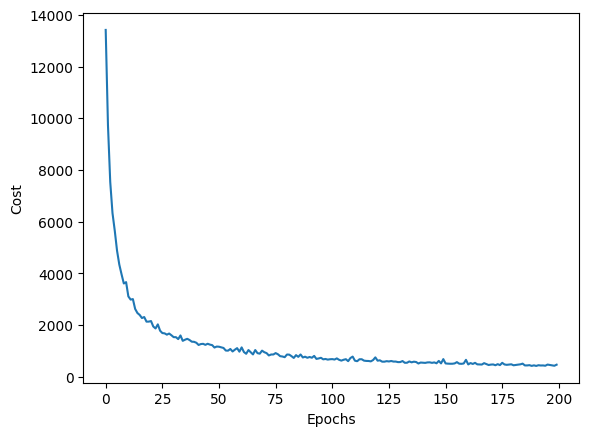

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

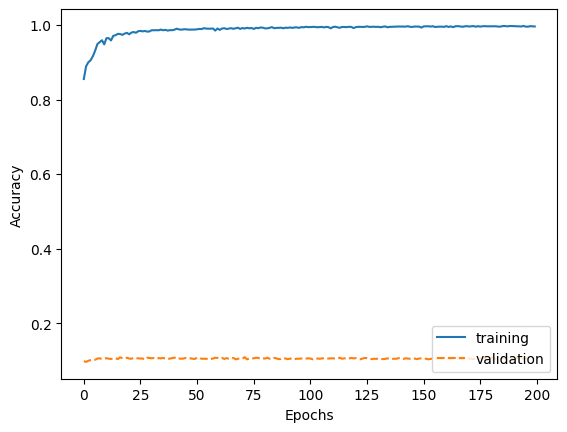

In [14]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [19]:
y_test_pred = nn.predict(x_test[1873:])
acc = (np.sum(y_test[1873:] == y_test_pred).astype(float) / x_test[1873:].shape[0])
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 96.43%
